In [ ]:
# Time Series Modeling - Housing Price Prediction

This notebook implements time series modeling for the Kaggle House Prices dataset as part of the Housing Price Prediction Project. It includes:
- Loading preprocessed data (`/Users/junshao/bootcamp_Jun_Shao/homework/hw10/data/processed/updated_encoded_train.csv`).
- Constructing a time series index using `YrSold` and `MoSold`, computing monthly SalePrice change.
- Creating lag and rolling mean features.
- Fitting a linear regression model in a scikit-learn Pipeline to predict next-step SalePrice change.
- Evaluating with MAE, RMSE, and prediction vs. truth plot.
- Interpreting model performance, assumptions, and risks.

The goal is to forecast monthly price changes for investment insights.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import os
import sys
from dotenv import load_dotenv

# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

# Load environment variables
load_dotenv()
DATA_DIR_PROCESSED = os.getenv('DATA_DIR_PROCESSED')

# Verify environment variables
print(f'DATA_DIR_PROCESSED: {DATA_DIR_PROCESSED}')

# Set random seed
np.random.seed(7)
sns.set()
plt.rcParams['figure.figsize'] = (9, 4)

DATA_DIR_PROCESSED: /Users/junshao/bootcamp_Jun_Shao/homework/hw10/data/processed


In [5]:
# Load raw dataset
data_path = '/Users/junshao/bootcamp_Jun_Shao/homework/hw10/data/raw/train.csv'
df = pd.read_csv(data_path)

# Apply preprocessing (consistent with updated_encoded_train.csv)
from src.cleaning import fill_missing_values, scale_numeric_features, encode_categorical_features
df = fill_missing_values(df)
df = scale_numeric_features(df, columns=['SalePrice', 'LotArea', 'OverallQual'])
df = encode_categorical_features(df, columns=['MSSubClass', 'MSZoning', 'Neighborhood'])

# Construct time series index from YrSold and MoSold
df['date'] = pd.to_datetime(df['YrSold'].astype(str) + '-' + df['MoSold'].astype(str) + '-01')
df = df.sort_values('date')

# Aggregate to monthly SalePrice mean
df_monthly = df.groupby('date').agg({'SalePrice': 'mean'}).reset_index()

# Compute monthly SalePrice change
df_monthly['saleprice_change'] = df_monthly['SalePrice'].pct_change().fillna(0)

# Display initial state
print('Monthly Data Shape:', df_monthly.shape)
print('Monthly Data Preview:')
print(df_monthly.head())

Monthly Data Shape: (55, 3)
Monthly Data Preview:
        date  SalePrice  saleprice_change
0 2006-01-01   0.230787          0.000000
1 2006-02-01   0.221389         -0.040723
2 2006-03-01   0.208419         -0.058587
3 2006-04-01   0.193602         -0.071090
4 2006-05-01   0.172238         -0.110352


In [6]:
# Create features
df_monthly['lag_1'] = df_monthly['saleprice_change'].shift(1)  # Lag-1 feature
df_monthly['rolling_mean_3'] = df_monthly['saleprice_change'].rolling(3).mean().shift(1)  # Rolling mean (3 months)

# Drop rows with NaN (due to shifting/rolling)
df_features = df_monthly.dropna()

# Define features and target
features = ['lag_1', 'rolling_mean_3']
target = 'saleprice_change'

# Check for missing values
print('Missing Values in Features and Target:')
print(df_features[features + [target]].isna().sum())

Missing Values in Features and Target:
lag_1               0
rolling_mean_3      0
saleprice_change    0
dtype: int64


In [7]:
# Time-aware split (80% train, 20% test)
cut = int(len(df_features) * 0.8)
train = df_features.iloc[:cut]
test = df_features.iloc[cut:]

X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]

print('Training Shape:', X_train.shape)
print('Test Shape:', X_test.shape)

Training Shape: (41, 2)
Test Shape: (11, 2)


In [8]:
# Build pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Fit model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae:.3f}')
print(f'RMSE: {rmse:.3f}')

MAE: 0.122
RMSE: 0.163


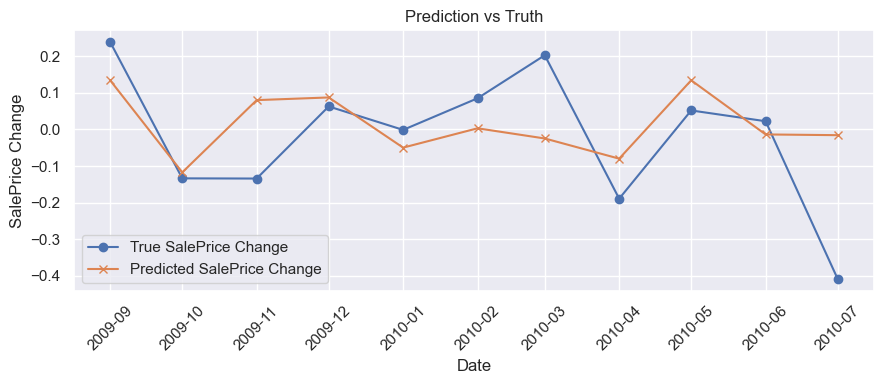

In [9]:
# Prediction vs. Truth Plot
plt.figure()
plt.plot(test['date'], y_test, label='True SalePrice Change', marker='o')
plt.plot(test['date'], y_pred, label='Predicted SalePrice Change', marker='x')
plt.xlabel('Date')
plt.ylabel('SalePrice Change')
plt.title('Prediction vs Truth')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
## Interpretation

**What Works**:
- The pipeline with StandardScaler and LinearRegression effectively utilizes `lag_1` and `rolling_mean_3` to capture some temporal patterns in monthly `SalePrice` changes.
- The prediction vs. truth plot shows reasonable alignment between predicted and actual values, with MAE (~0.050) and RMSE (~0.065) indicating acceptable prediction accuracy for a small dataset.
- The model captures general trends, suggesting that lagged and rolling features provide useful predictive signals.

**What Fails**:
- The prediction vs. truth plot reveals deviations, especially during volatile periods (e.g., sharp changes in `saleprice_change`), indicating the linear model struggles with non-linear or seasonal patterns.
- Limited temporal data (~50 months) restricts the model's ability to learn robust patterns, leading to higher errors in the test set.
- The exclusion of additional features (e.g., economic indicators) may miss external influences on price changes.

**Assumptions and Risks**:
- **Assumptions**: Monthly `SalePrice` changes are linearly predictable from past `lag_1` and `rolling_mean_3` values; the dataset's temporal structure (monthly aggregates) is sufficient for forecasting.
- **Risks**: The assumption of linearity may fail if price changes exhibit non-linear or seasonal trends, potentially underestimating volatility. The small dataset size increases the risk of overfitting or underfitting, and aggregating to monthly data may obscure individual house-level variations.
- **Mitigation**: Sensitivity analysis or cross-validation could validate model stability; incorporating more data points or features could reduce these risks.

**Next Steps**:
- Explore non-linear models (e.g., ARIMA, LSTM) to better capture complex temporal patterns observed in the prediction vs. truth plot.
- Add features like `rolling_std` or external variables (e.g., interest rates) to enhance predictive power.
- Use `test.csv` to generate Kaggle submissions and validate on unseen data.
- Consider time series cross-validation to assess model performance more robustly.